# Convolutional Neural Networks (LeNet)

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## LeNet

At a high level, (**LeNet (LeNet-5) consists of two parts:
(i) a convolutional encoder consisting of two convolutional layers; and
(ii) a dense block consisting of three fully connected layers**).


![Data flow in LeNet. The input is a handwritten digit, the output is a probability over 10 possible outcomes.](../images/lenet.svg)


The basic units in each convolutional block
are a convolutional layer, a sigmoid activation function,
and a subsequent average pooling operation.
Note that while ReLUs and max-pooling work better,
they had not yet been discovered.
Each convolutional layer uses a $5\times 5$ kernel
and a sigmoid activation function.
These layers map spatially arranged inputs
to a number of two-dimensional feature maps, typically
increasing the number of channels.
The first convolutional layer has 6 output channels,
while the second has 16.
Each $2\times2$ pooling operation (stride 2)
reduces dimensionality by a factor of $4$ via spatial downsampling.
The convolutional block emits an output with shape given by
(batch size, number of channel, height, width).

In order to pass output from the convolutional block
to the dense block,
we must flatten each example in the minibatch.
In other words, we take this four-dimensional input and transform it
into the two-dimensional input expected by fully connected layers:
as a reminder, the two-dimensional representation that we desire uses the first dimension to index examples in the minibatch
and the second to give the flat vector representation of each example.
LeNet's dense block has three fully connected layers,
with 120, 84, and 10 outputs, respectively.
Because we are still performing classification,
the 10-dimensional output layer corresponds
to the number of possible output classes.

While getting to the point where you truly understand
what is going on inside LeNet may have taken a bit of work,
we hope that the following code snippet will convince you
that implementing such models with modern deep learning frameworks
is remarkably simple.
We need only to instantiate a `Sequential` block
and chain together the appropriate layers,
using Xavier initialization as
introduced.

> For the code below... we have explore how the *initialization* works. Head over to the `5. Builder's practive > 2. Parameter initialization.ipynb` book 😀

In [2]:
def init_cnn(module):  #@save
    """
    Initialize weights for CNNs.

    This function will be called *module-by-module*. It will receive 
    individiual layers and will then initialize it.

    We need to check whether their types are Linear or Conv2D
    else we will encounter an error for the Activation inits.
    """
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [82]:
class LeNet(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

## Let's see it layer-by-layer

In [83]:
X = torch.randn(1, 28, 28)
X.shape

torch.Size([1, 28, 28])

In [84]:
K = nn.LazyConv2d(6, kernel_size=5, padding=2)
K(X).shape

torch.Size([6, 28, 28])

1. Now we have an image with single channel -> output is 6 channels

In [85]:
K = nn.LazyConv2d(6, kernel_size=5)
K(X).shape

torch.Size([6, 24, 24])

2. **Without padding** we are shrinking the size.

In [86]:
X = torch.randn(3, 28, 28)
X.shape

torch.Size([3, 28, 28])

In [87]:
K = nn.LazyConv2d(6, kernel_size=5, padding=2)
K(X).shape

torch.Size([6, 28, 28])

3. Image has 3 channels and we have successfully worked with them.

We have taken some liberty in the reproduction of LeNet insofar as we have replaced the Gaussian activation layer by
a softmax layer. This greatly simplifies the implementation, not least due to the
fact that the Gaussian decoder is rarely used nowadays. Other than that, this network matches
the original LeNet-5 architecture.


Let's see what happens inside the network. By passing a
single-channel (black and white)
$28 \times 28$ image through the network
and printing the output shape at each layer,
we can [**inspect the model**] to ensure
that its operations line up with
what we expect from :numref:`img_lenet_vert`.


![Compressed notation for LeNet-5.](../images/lenet-vert.svg)

In [88]:
@d2l.add_to_class(d2l.Classifier)  #@save
def layer_summary(self, X_shape):
    # basically we will need to *pass* something there as there are LazyLayers
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [89]:
model = LeNet()

# these are the **image outputs** between layers and **not** the parameters of the model to be learnt.
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [90]:
# these are **actual** parameters that will be learnt
for i in model.parameters():
    print(i.shape)

torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


In [91]:
# Iterate through the model's layers and parameters
for name, layer in model.named_modules():
    # Check if the layer has parameters (e.g., Conv2d, Linear)
    if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):
        print(f"Layer: {name}")
        for param in layer.parameters():
            print(f"  Parameter: {param.shape}")

Layer: net.0
  Parameter: torch.Size([6, 1, 5, 5])
  Parameter: torch.Size([6])
Layer: net.3
  Parameter: torch.Size([16, 6, 5, 5])
  Parameter: torch.Size([16])
Layer: net.7
  Parameter: torch.Size([120, 400])
  Parameter: torch.Size([120])
Layer: net.9
  Parameter: torch.Size([84, 120])
  Parameter: torch.Size([84])
Layer: net.11
  Parameter: torch.Size([10, 84])
  Parameter: torch.Size([10])


In [92]:
# 6 * 1 * 5 * 5
next(model.parameters()).numel()

150

In [93]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 61706


# 

Note that the height and width of the representation
at each layer throughout the convolutional block
is reduced (compared with the previous layer).
The first convolutional layer uses two pixels of padding
to compensate for the reduction in height and width
that would otherwise result from using a $5 \times 5$ kernel.
As an aside, the image size of $28 \times 28$ pixels in the original
MNIST OCR dataset is a result of *trimming* two pixel rows (and columns) from the
original scans that measured $32 \times 32$ pixels. This was done primarily to
save space (a 30% reduction) at a time when megabytes mattered.

In contrast, the second convolutional layer forgoes padding,
and thus the height and width are both reduced by four pixels.
As we go up the stack of layers,
the number of channels increases layer-over-layer
from 1 in the input to 6 after the first convolutional layer
and 16 after the second convolutional layer.
However, each pooling layer halves the height and width.
Finally, each fully connected layer reduces dimensionality,
finally emitting an output whose dimension
matches the number of classes.


## Training

Now that we have implemented the model,
let's [**run an experiment to see how the LeNet-5 model fares on Fashion-MNIST**].

While CNNs have fewer parameters,
they can still be more expensive to compute
than similarly deep MLPs
because each parameter participates in many more
multiplications.
If you have access to a GPU, this might be a good time
to put it into action to speed up training.
Note that
the `d2l.Trainer` class takes care of all details.
By default, it initializes the model parameters on the
available devices.
Just as with MLPs, our loss function is cross-entropy,
and we minimize it via minibatch stochastic gradient descent.


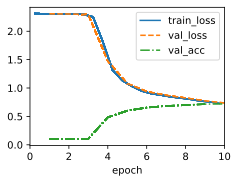

In [94]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

In [104]:
torch.save(model.state_dict(), './LeNet-5.params')

# Looking inside.

## Some testing first

In [101]:
import matplotlib.pyplot as plt

In [102]:
model

LeNet(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): Sigmoid()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): Sigmoid()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [109]:
data.train.data.shape

torch.Size([60000, 28, 28])

In [119]:
sample = data.train.data[0]

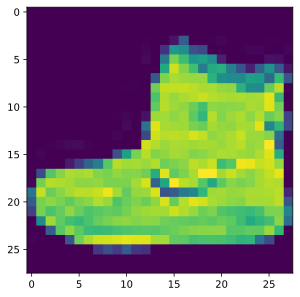

In [121]:
plt.imshow(sample);

In [124]:
print(sample.shape)
sample = sample.reshape(1, 1, 28, 28)
print(sample.shape)

torch.Size([28, 28])
torch.Size([1, 1, 28, 28])


In [ ]:
sample = sample.to(torch.float32).cuda()
pred = nn.Softmax()(model(sample))
pred.argmax()

In [164]:
for i in zip(range(10), data.text_labels(range(10))):
    print(i)

(0, 't-shirt')
(1, 'trouser')
(2, 'pullover')
(3, 'dress')
(4, 'coat')
(5, 'sandal')
(6, 'shirt')
(7, 'sneaker')
(8, 'bag')
(9, 'ankle boot')


YES!!!

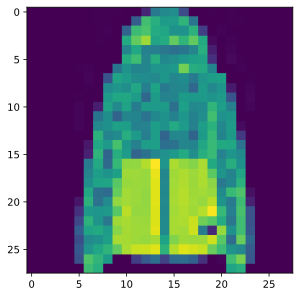

In [219]:
sample = data.train.data[22]
plt.imshow(sample);

In [171]:
print(sample.shape)
sample = sample.reshape(1, 1, 28, 28)
print(sample.shape)

sample = sample.to(torch.float32).cuda()
pred = nn.Softmax()(model(sample))
pred.argmax()

torch.Size([28, 28])
torch.Size([1, 1, 28, 28])


tensor(4, device='cuda:0')

Freaking amazing!!

## 🤫 Opening the model

## `1.` Layer - 1 - CONV

In [34]:
def plot_kernels(kernels, n_cols):
    """
    Function to automatically plot kernels in a grid of subplots.

    :param kernels: List or numpy array of kernels to plot.
    :param n_cols: The number of columns in the grid.
    """
    n_kernels = len(kernels)
    
    # Calculate number of rows based on the number of kernels and columns
    n_rows = (n_kernels + n_cols - 1) // n_cols  # Equivalent to ceil(n_kernels / n_cols)
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), dpi=100)
    
    # Flatten axes array to make indexing easier
    axes = axes.flatten()
    
    # Plot each kernel
    for i in range(n_kernels):
        axes[i].imshow(torch.squeeze(kernels[i]).cpu().detach().numpy(), cmap="gray")
        axes[i].axis('off')  # Optional: to hide axes for better visualization
    
    # Hide extra axes if there are fewer kernels than subplots
    for i in range(n_kernels, len(axes)):
        axes[i].axis('off')
    
    plt.show()

### `1.1` Seeling the weights

In [177]:
first_layer = model.net[0]

In [184]:
# This first layer has 6 kernels, each with single channel and 5x5 shape
kernels_6 = first_layer.weight
kernels_6.shape

torch.Size([6, 1, 5, 5])

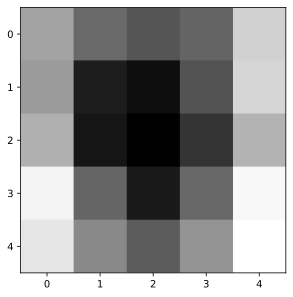

In [210]:
# first kernel, first channel
plt.imshow(kernels_6[0][0].cpu().detach().numpy(), cmap="gray");

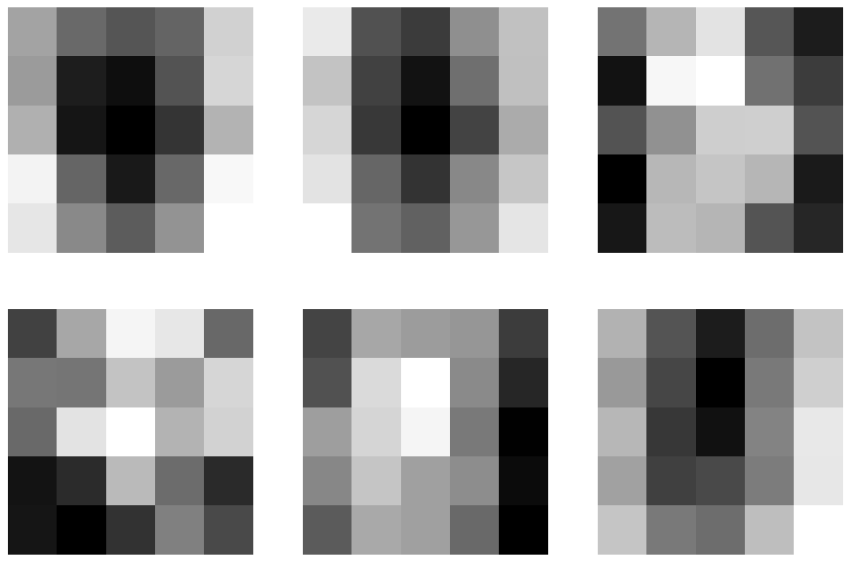

In [266]:
# Example usage with kernels_6 (assuming kernels_6 is defined)
plot_kernels(kernels_6, n_cols=3)

> ## 👆🏻
> The above are the **learned weights** they themselves may not mean much. We need to pass some image to see what the resultant image looks like in practice.

### `1.2` Seeing the output

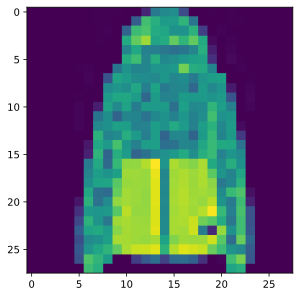

In [271]:
sample = data.train.data[22]
plt.imshow(sample);

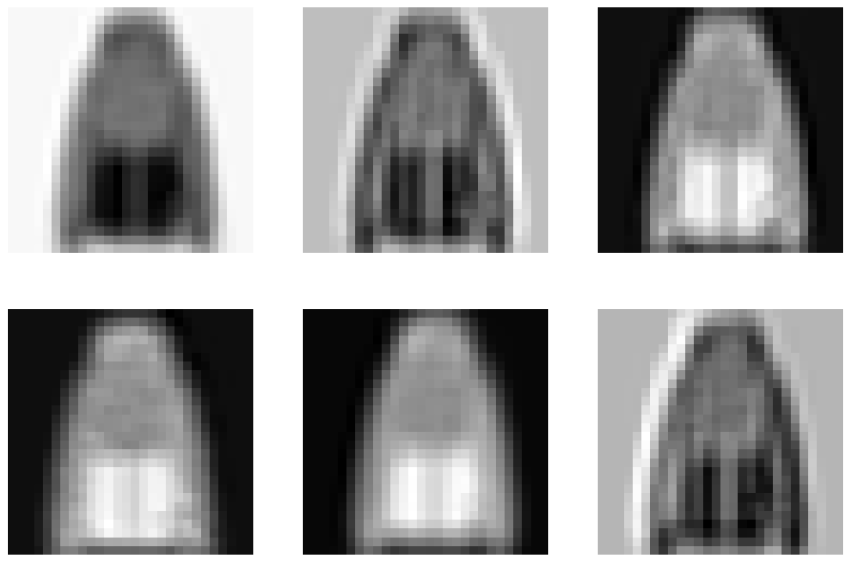

In [272]:
sample = sample.reshape((1, 1, 28, 28))
sample = sample.to(torch.float32).cuda()

first_layer_result = first_layer(sample)
feature_mapes = first_layer_result[0]

plot_kernels(feature_mapes, n_cols=3)

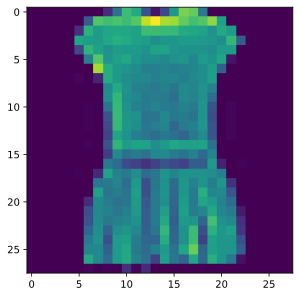

In [254]:
sample = data.train.data[3]
plt.imshow(sample);

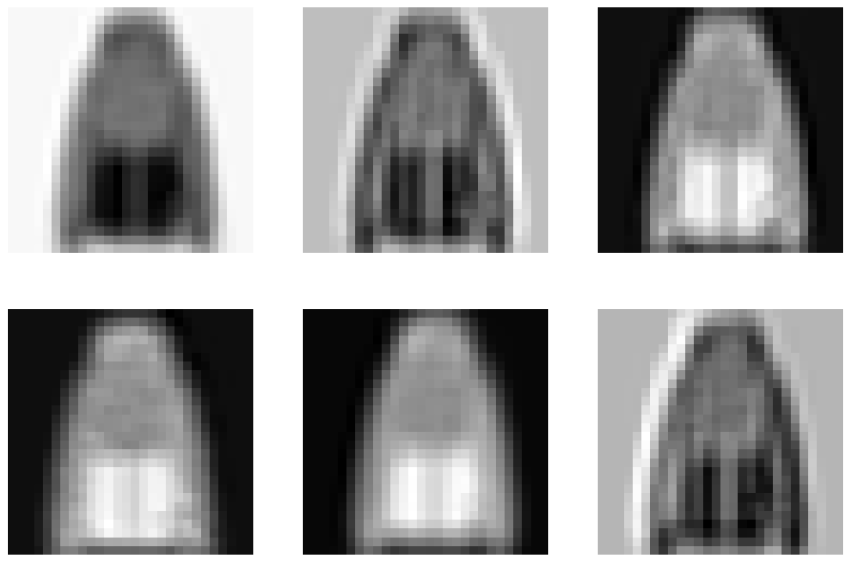

In [273]:
sample = sample.reshape((1, 1, 28, 28))
sample = sample.to(torch.float32).cuda()

first_layer_result = first_layer(sample)
feature_mapes = first_layer_result[0]

plot_kernels(feature_mapes, n_cols=3)

Looks like:
- First one detects the back ground
- Third seperates the object
- 2, 4, 5 highlights some *internal* features
- 6th detects object *curvatures*

> ## 👆🏻
> The above are finally something which model **sees**... let's see how the Pooling works.

## `2.` Layer - 2: Pooling

In [274]:
model.net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [276]:
# first_layer = model.net[0]
first_layer_layer_activation = model.net[1]
first_pool = model.net[2]

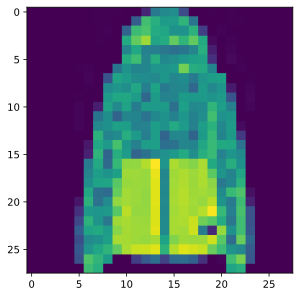

In [275]:
sample = data.train.data[22]
plt.imshow(sample);

In [279]:
sample = sample.reshape((1, 1, 28, 28))
sample = sample.to(torch.float32).cuda()

first_layer_result = first_layer(sample)
first_layer_result = first_layer_layer_activation(first_layer_result)
first_pool_result = first_pool(first_layer_result)
first_pool_result.shape

torch.Size([1, 6, 14, 14])

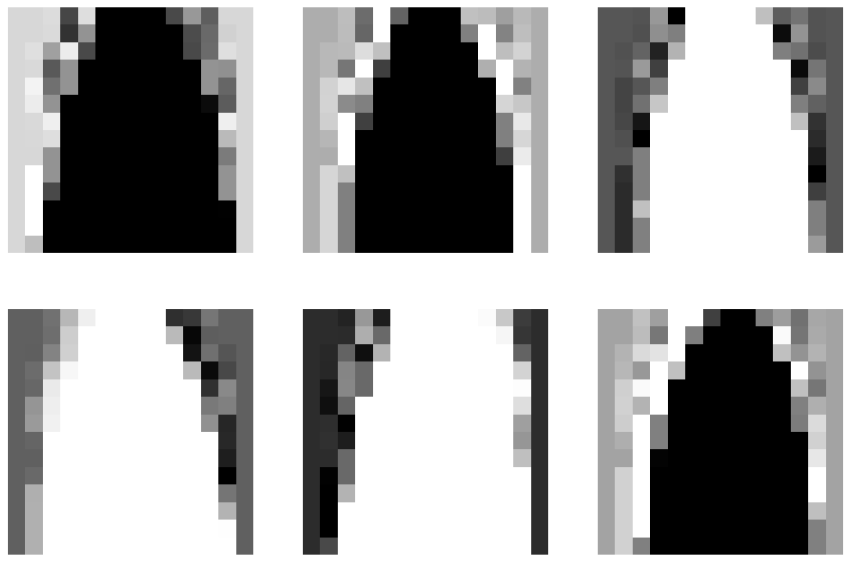

In [280]:
pool_results = first_pool_result[0]
plot_kernels(pool_results, n_cols=3)

> ## 👆🏻
> This is the average pool! See how **it seperates** the stuff.

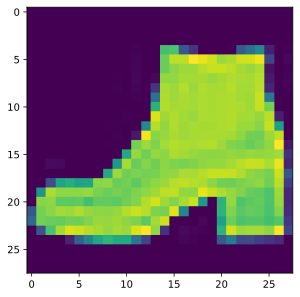

In [287]:
sample = data.train.data[122]
plt.imshow(sample);

In [288]:
sample = sample.reshape((1, 1, 28, 28))
sample = sample.to(torch.float32).cuda()

first_layer_result = first_layer(sample)
first_layer_result = first_layer_layer_activation(first_layer_result)
first_pool_result = first_pool(first_layer_result)
first_pool_result.shape

torch.Size([1, 6, 14, 14])

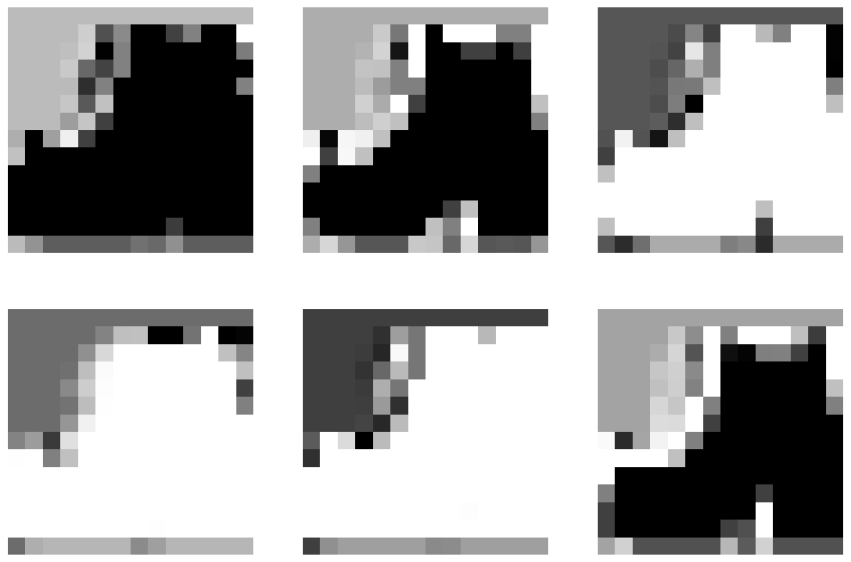

In [289]:
pool_results = first_pool_result[0]
plot_kernels(pool_results, n_cols=3)

## `3.` Layer - 3: Second Convolution

In [290]:
model.net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [291]:
# first_layer = model.net[0]
# first_layer_layer_activation = model.net[1]
# first_pool = model.net[2]

second_layer = model.net[3]

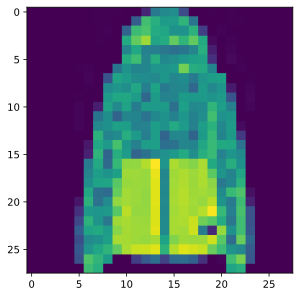

In [292]:
sample = data.train.data[22]
plt.imshow(sample);

In [293]:
sample = sample.reshape((1, 1, 28, 28))
sample = sample.to(torch.float32).cuda()

first_layer_result = first_layer(sample)
first_layer_result = first_layer_layer_activation(first_layer_result)
first_pool_result = first_pool(first_layer_result)

second_layer_result = second_layer(first_pool_result)
second_layer_result.shape

torch.Size([1, 16, 10, 10])

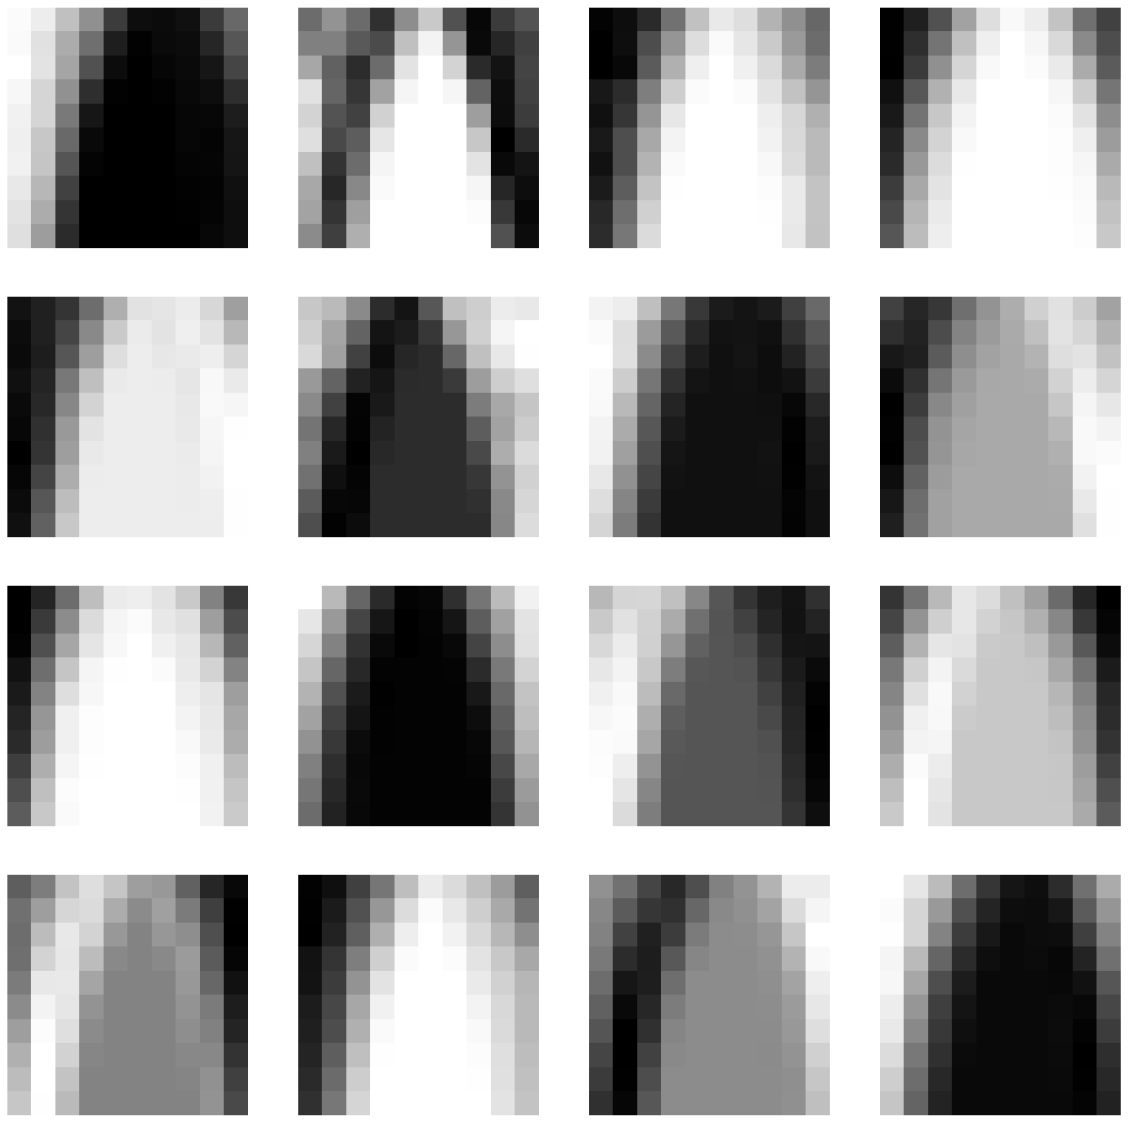

In [295]:
second_layer_results = second_layer_result[0]
plot_kernels(second_layer_results, n_cols=4)

> ## 😅
> Damn... now it is a **blurry vision** for the model...

## Summary

We have made significant progress in this chapter. We moved from the MLPs of the 1980s to the CNNs of the 1990s and early 2000s. The architectures proposed, e.g., in the form of LeNet-5 remain meaningful, even to this day. It is worth comparing the error rates on Fashion-MNIST achievable with LeNet-5 both to the very best possible with MLPs (:numref:`sec_mlp-implementation`) and those with significantly more advanced architectures such as ResNet (:numref:`sec_resnet`). LeNet is much more similar to the latter than to the former. One of the primary differences, as we shall see, is that greater amounts of computation enabled significantly more complex architectures.

A second difference is the relative ease with which we were able to implement LeNet. What used to be an engineering challenge worth months of C++ and assembly code, engineering to improve SN, an early Lisp-based deep learning tool :cite:`Bottou.Le-Cun.1988`, and finally experimentation with models can now be accomplished in minutes. It is this incredible productivity boost that has democratized deep learning model development tremendously. In the next chapter we will journey down this rabbit to hole to see where it takes us.


## Exercises

1. **Let's modernize LeNet. Implement and test the following changes:**
    1. Replace average pooling with max-pooling.
    1. Replace the softmax layer with ReLU.


### First, let's see the current model's accuracy

In [300]:
val = data.val

In [304]:
X_test = val.data
y_test = val.targets

In [308]:
X_test.shape

torch.Size([10000, 28, 28])

In [315]:
X_test = X_test.reshape(10000, 1, 28, 28)
X_test = X_test.to(torch.float32).cuda()

In [320]:
test_logits = model(X_test)
test_logits.shape

torch.Size([10000, 10])

In [329]:
y_pred = torch.argmax(test_logits, axis=1).cpu().detach().numpy()

In [326]:
from sklearn.metrics import accuracy_score, classification_report

In [331]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.69      0.80      0.74      1000
           1       0.97      0.91      0.94      1000
           2       0.39      0.85      0.53      1000
           3       0.77      0.60      0.67      1000
           4       0.57      0.48      0.52      1000
           5       0.99      0.51      0.68      1000
           6       0.30      0.02      0.04      1000
           7       0.82      0.67      0.74      1000
           8       0.68      0.90      0.78      1000
           9       0.73      0.98      0.84      1000

    accuracy                           0.67     10000
   macro avg       0.69      0.67      0.65     10000
weighted avg       0.69      0.67      0.65     10000



### Retrain the model with *ReLU* and *MaxPool*

In [332]:
class LeNet_v2(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(), # change
            nn.MaxPool2d(kernel_size=2, stride=2), # change
            
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(), # change
            nn.MaxPool2d(kernel_size=2, stride=2), # change
            
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [333]:
LeNet_v2().layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
ReLU output shape:	 torch.Size([1, 16, 10, 10])
MaxPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


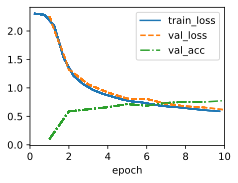

In [336]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=512)
model_2 = LeNet_v2(lr=0.1)
model_2.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model_2, data)

In [337]:
test_logits = model_2(X_test)
test_logits.shape

torch.Size([10000, 10])

In [338]:
y_pred = torch.argmax(test_logits, axis=1).cpu().detach().numpy()

In [339]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76      1000
           1       0.97      0.90      0.93      1000
           2       0.66      0.56      0.60      1000
           3       0.73      0.86      0.79      1000
           4       0.51      0.84      0.63      1000
           5       0.93      0.92      0.92      1000
           6       0.34      0.06      0.10      1000
           7       0.92      0.89      0.90      1000
           8       0.88      0.96      0.92      1000
           9       0.90      0.94      0.92      1000

    accuracy                           0.77     10000
   macro avg       0.75      0.77      0.75     10000
weighted avg       0.75      0.77      0.75     10000



> Daaamn! We are able to increase it by 77%!

2. **Try to change the size of the LeNet style network to improve its accuracy in addition to max-pooling and ReLU.**
    1. Adjust the convolution window size.
    1. Adjust the number of output channels.
    1. Adjust the number of convolution layers.
    1. Adjust the number of fully connected layers.
    1. Adjust the learning rates and other training details (e.g., initialization and number of epochs).

In [2]:
class LeNet_v3(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=3, padding=1), nn.ReLU(), # change
            nn.MaxPool2d(kernel_size=3, stride=2), # change
            
            nn.LazyConv2d(16, kernel_size=3, padding=1), nn.ReLU(), # change
            nn.MaxPool2d(kernel_size=3, stride=2), # change
            
            nn.Flatten(),
            nn.LazyLinear(256), nn.Sigmoid(),
            nn.LazyLinear(128), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [353]:
temp = LeNet_v3()
temp.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
ReLU output shape:	 torch.Size([1, 6, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 6, 13, 13])
Conv2d output shape:	 torch.Size([1, 16, 13, 13])
ReLU output shape:	 torch.Size([1, 16, 13, 13])
MaxPool2d output shape:	 torch.Size([1, 16, 6, 6])
Flatten output shape:	 torch.Size([1, 576])
Linear output shape:	 torch.Size([1, 256])
Sigmoid output shape:	 torch.Size([1, 256])
Linear output shape:	 torch.Size([1, 128])
Sigmoid output shape:	 torch.Size([1, 128])
Linear output shape:	 torch.Size([1, 10])


In [354]:
total_params = sum(p.numel() for p in temp.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 182838


> We now have 20K more!

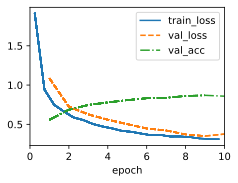

In [355]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=256)
model_3 = LeNet_v3(lr=0.3)
model_3.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model_3, data)

In [356]:
test_logits = model_3(X_test)
test_logits.shape

torch.Size([10000, 10])

In [357]:
y_pred = torch.argmax(test_logits, axis=1).cpu().detach().numpy()

In [358]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.69      0.92      0.79      1000
           1       0.93      0.97      0.95      1000
           2       0.65      0.86      0.74      1000
           3       0.91      0.79      0.84      1000
           4       0.75      0.71      0.73      1000
           5       0.94      0.97      0.95      1000
           6       0.77      0.35      0.48      1000
           7       0.88      0.95      0.91      1000
           8       0.94      0.98      0.96      1000
           9       0.99      0.88      0.93      1000

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.83     10000
weighted avg       0.85      0.84      0.83     10000



> Holy!

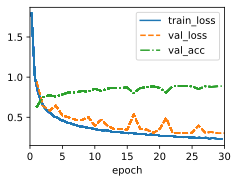

In [359]:
trainer = d2l.Trainer(max_epochs=30, num_gpus=1) ## 30!?
data = d2l.FashionMNIST(batch_size=256)
model_4 = LeNet_v3(lr=0.3)
model_4.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model_4, data)

In [363]:
test_logits = model_4(X_test)
test_logits.shape

torch.Size([10000, 10])

In [364]:
y_pred = torch.argmax(test_logits, axis=1).cpu().detach().numpy()

In [365]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1000
           1       0.98      0.98      0.98      1000
           2       0.79      0.82      0.80      1000
           3       0.95      0.82      0.88      1000
           4       0.69      0.90      0.78      1000
           5       0.99      0.97      0.98      1000
           6       0.79      0.54      0.64      1000
           7       0.95      0.96      0.96      1000
           8       0.97      0.98      0.97      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



In [366]:
torch.save(model_4.state_dict(), './LeNet-5_v4.params')

3. **What happens to the activations when you feed significantly different images into the network (e.g., cats, cars, or even random noise)?**

In [367]:
from torchvision import transforms
from PIL import Image

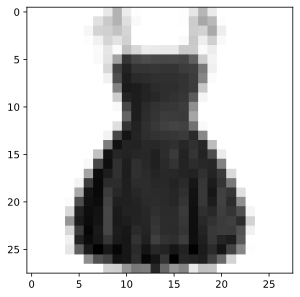

In [395]:
image = Image.open('../images/dress-clean.png')  # Replace with your image path
image_resized = image.resize((28, 28))
transform = transforms.ToTensor()
image_resized = transform(image_resized)
plt.imshow(image_resized.squeeze(0), cmap="gray");

In [396]:
image_resized = image_resized.reshape(1, 1, 28, 28)

In [397]:
image_resized = image_resized.cuda()

In [398]:
nn.Softmax()(model(image_resized)).argmax()

tensor(2, device='cuda:0')

In [379]:
for i in zip(range(10), data.text_labels(range(10))):
    print(i)

(0, 't-shirt')
(1, 'trouser')
(2, 'pullover')
(3, 'dress')
(4, 'coat')
(5, 'sandal')
(6, 'shirt')
(7, 'sneaker')
(8, 'bag')
(9, 'ankle boot')


OH! REAL?

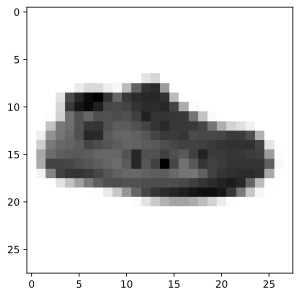

In [400]:
image = Image.open('../images/sandal.png')  # Replace with your image path
image_resized = image.resize((28, 28))
transform = transforms.ToTensor()
image_resized = transform(image_resized)
plt.imshow(image_resized.squeeze(0), cmap="gray");

In [401]:
image_resized = image_resized.reshape(1, 1, 28, 28)
image_resized = image_resized.cuda()

In [405]:
nn.Softmax()(model(image_resized)).argmax()

tensor(0, device='cuda:0')

In [403]:
for i in zip(range(10), data.text_labels(range(10))):
    print(i)

(0, 't-shirt')
(1, 'trouser')
(2, 'pullover')
(3, 'dress')
(4, 'coat')
(5, 'sandal')
(6, 'shirt')
(7, 'sneaker')
(8, 'bag')
(9, 'ankle boot')


> WRONGGG!!!!

In [422]:
class LeNet(d2l.Classifier):  #@save
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            
            nn.LazyConv2d(16, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

Point(x=10.0, y=0.8763844936708861)


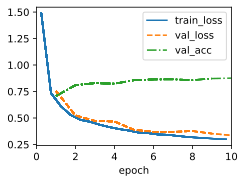

In [424]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1) ## 30!?
data = d2l.FashionMNIST(batch_size=128)
model_5 = LeNet(lr=0.2)
model_5.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model_5, data)
print(model_5.board.data['val_acc'][-1])

In [425]:
test_logits = model_5(X_test)
test_logits.shape

torch.Size([10000, 10])

In [426]:
total_params = sum(p.numel() for p in model_5.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 107786


In [427]:
y_pred = torch.argmax(test_logits, axis=1).cpu().detach().numpy()

In [429]:
print(classification_report(y_pred=y_pred, y_true=y_test))

              precision    recall  f1-score   support

           0       0.71      0.90      0.80      1000
           1       0.98      0.96      0.97      1000
           2       0.82      0.74      0.78      1000
           3       0.90      0.82      0.86      1000
           4       0.71      0.85      0.77      1000
           5       0.96      0.96      0.96      1000
           6       0.74      0.51      0.61      1000
           7       0.95      0.93      0.94      1000
           8       0.93      0.98      0.96      1000
           9       0.95      0.96      0.96      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



# Testing with some noisy inputs!

In [14]:
import matplotlib.pyplot as plt

In [10]:
loaded_model = LeNet_v3().cuda()

In [11]:
loaded_model.load_state_dict(torch.load('./LeNet-5_v4.params', weights_only=True))

<All keys matched successfully>

In [12]:
X_noise = torch.randn((28, 28), device="cuda")

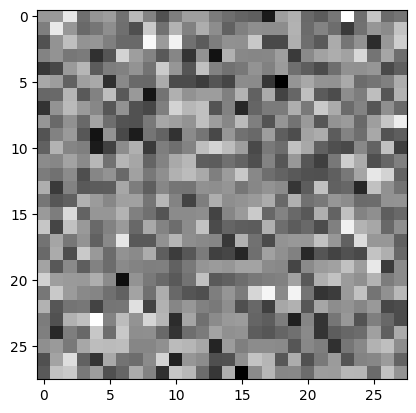

In [16]:
plt.imshow(X_noise.squeeze(0).cpu().detach().numpy(), cmap="gray");

In [17]:
X_noise = X_noise.reshape(1, 1, 28, 28)

In [20]:
nn.Softmax()(loaded_model(X_noise)).argmax()

tensor(8, device='cuda:0')

In [33]:
torch.round(nn.Softmax()(loaded_model(X_noise)), decimals=2)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0600, 0.0000, 0.0000, 0.9400,
         0.0000]], device='cuda:0', grad_fn=<RoundBackward1>)

Buddy is confident about the "bag" here!

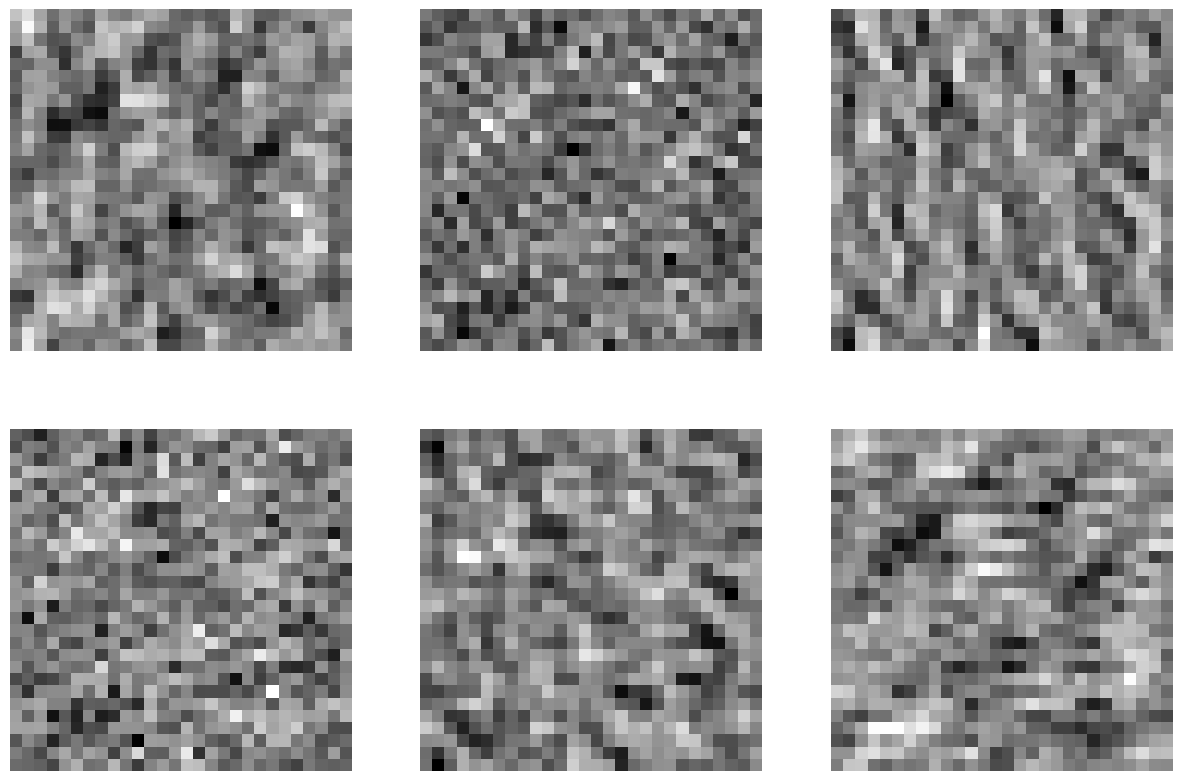

In [36]:
first_layer = loaded_model.net[0]
first_layer_result = first_layer(X_noise)
feature_mapes = first_layer_result[0]

plot_kernels(feature_mapes, n_cols=3)

Let's freaking leave it here 💀

[Discussions](https://discuss.d2l.ai/t/74)
